## TUGAS BESAR 1

Lakukan ulang metode di atas untuk jumlah data training dan testing yang lebih banyak. Anda diperbolehkan untuk menggunakan data sebanyak-banyaknya (tidak terbatas pada data yang diberikan), mengganti metode augmentasi, melakukan tuning hyperparameter, mengganti arsitektur, menggunakan pretrained model lain, dan menentukan performance metric yang menurut anda baik.

Pada folder tugas besar terdapat tiga folder dataset, berikut penjelasan untuk masing-masing folder.

*   sample_dataset: merupakan hasil sampling dari Dr Cohen's Dataset, berisi 25 data x-ray normal dan 25 data x-ray Covid-19.
*   sansten_dataset: merupakan data hasil sampling dari Dr Cohen's Dataset, berisi 102 data x-ray normal, 102 data x-ray bacterial pneumonia, dan 95 data Covid-19.
*   chestimaging_dataset: merupakan data 51 kasus Covid-19, jumlah gambar setiap kasus beragam.

Tidak semua dataset bersih dan dapat langsung digunakan, pastikan untuk mengecek satu-persatu dataset sebelum melakukan training. Misalnya pada dataset yang diberikan terdapat x-ray yang diambil dari penampang lain, terdapat hasil ct scan, dll. Penggunaan dataset yang tidak teratur dapat menurunkan performa model.



Referensi:

Dataset
*   Dr Cohen's Dataset: https://github.com/ieee8023/covid-chestxray-dataset
*   Audrey's Dataset: https://github.com/agchung/Figure1-COVID-chestxray-dataset
*   Kaggle NIH Dataset: https://www.kaggle.com/nih-chest-xrays/data
*   @ChestImaging's Dataset: https://twitter.com/i/status/1243928581983670272
*   COVIDx Dataset: https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md

Github
*   COVID-Net: https://github.com/lindawangg/COVID-Net

Tutorial (source code tugas ini)
*   https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/





## Alur Tugas Besar
Notebook tugas besar ini dibagi menjadi beberapa langkah sebagai berikut. Silahkan diperhatikan dan dipahami alur dan detail setiap langkah.
1. Notebook Setting
2. Environment Setting
3. Dataset Preparation
3. Label Separation
4. Label One-Hot-Encoding
5. Model Definition
6. Hyperparameters
7. Optimizer and Loss Function
8. Model Training
9. Model Evaluation
10. Eksperimen Model Machine Learning Lain(Opsional)
11. Implementasi Model

## 1. Notebook Setting


Pengaturan notebook ini bertujuan untuk mengatur penggunaan GPU sebagai runtime Notebook. GPU dibutuhkan karena komputasi yang akan kita lakukan cukup besar. Pemrosesan menggunakan CPU akan menghabiskan waktu yang sangat lama.

In [0]:
# Check for listed GPU

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15181493965985199418
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 818416850547180379
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8500546168709532087
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14918078458537505266
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
# Check for selected GPU

!nvidia-smi

Mon May 18 21:52:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Mount google drive to our notebook

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 2. Environment Setting

Pengaturan environment menentukan library apa saja yang digunakan. Ingat selalu untuk mengimport library yang dibutuhkan saja.

In [0]:
# import dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

## 3. Datasets Preparation

Dataset sample yang diberikan sudah terbagi ke dalam 2 folder normal dan covid, masing-masing folder berisi 25 data gambar. Data ini sangat sedikit, tidak bisa merepresentasi kasus yang sebenarnya. Pada praktiknya, data yang dibutuhkan jumlahnya ribuan hingga puluhan ribu untuk masing-masing kelas.

In [0]:
# initialize path and name for datasets, plot image, and model
dataset = "/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi"
plot_name = "plot2.png"
model_name = "covid19_2.model"

# initialize data(image) and label from dataset directory
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

[INFO] loading images...


In [0]:
print(imagePaths)
print("number of data: {}".format(len(imagePaths)))

['/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg', '/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg', '/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg', '/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', '/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi/covid/2_7C69C012-7479-493F-8722-ABC29C60A2DD-1024x1019.jpeg', '/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi/covid/4_2C10A413-AABE-4807-8CCE-6A2025594067-1024x839.jpeg', '/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi/covid/7_E1724330-1866-4581-8CD8-CEC9B8AFEDDE-1024x839.jpeg', '/content/gdrive/My Drive/Tubes DSKC 2020 - Covid19/test_data_gnumi/covid/8_9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg', '/content/gdrive/My Drive/Tubes

## 4. Label Separation

Untuk setiap gambar, dibuat label yang sesuai dengan kelasnya. Pemberian label dilakukan dengan membaca parent folder dari setiap gambar. Di akhir proses, semua data diubah bentuknya ke dalam NumPy array. Kemudian data dinormalisasi sehingga nilai pixelnya berada di antara 0 dan 1.

In [0]:
# loop over the image paths, extract data and label, and preprocess image
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	data.append(image)
	labels.append(label)
 
# convert to NumPy arrays and normalize to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)


In [0]:
# just a sanity check, as usual

print(len(data))
print(len(labels))
#print(data)
print(labels)

696
696
['covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid' 'covid'
 'covid' 'covid' 'covid' 'covid' 'covid' 'c

## 5. One-hot Encoding and Data Augmentation

Dalam keras, data label perlu diolah menjadi matriks yang tiap baris berupa vektor nilai nol atau satu. Data label tersebut perlu dioleh dengan metode One-Hot-Encoding.

Proses selanjutnya adalah data augmentasi.


**Pertanyaan 1**: Apa itu data augmentasi dan apa pengaruhnya pada performa model? Jelaskan juga mengapa data augmentation pada poin 9 hanya dilakukakn untuk data train?

**Jawaban:** (silahkan klik dua kali cell ini)

Data Augmentation merupakan salah satu teknik untuk memperbanyak jumlah model data yang akan digunakan tanpa menambah gambar / data baru. Hal ini dicapai dengan cara menduplikasi suatu gambar/data yang telah ada dan kemudian dilakukan pengolahan data/gambar pada data yang telah diduplikasi seperti penambahan derau/noise pada gambar, dilakukan rotasi, flipping, zoom dan berbagai proses pengubahan gambar sehingga tercipta gambar baru yang masih dikenali sebagai data yang sama. 

Dengan demikian, penggunaan teknik data augmentasi akan meningkatkan performa model yang digunakan. Hal ini karena semakin banyak variasi dataset yang digunakan untuk diproses tanpa harus menambah data baru.

Data augmentasi dilakukan hanya pada data train. Hal ini dikarenakan semakin banyak variasi data pada proses pelatihan/training yang digunakan maka akan semakin baik performa dalam melakukan pembuatan model data.

In [0]:
# one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# split dataset to train and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# initialize data augmentation
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")


In [0]:
# better_augmentation
# trainAug = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.1,
#     horizontal_flip=True,
#    fill_mode='nearest')



In [0]:
# sanity check, again

print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## 6. Model Definition

Arsitektur yang digunakan pada tugas ini adalah ResNet152v2.

Notes for ResNet152v2 arguments

```python
tf.keras.applications.ResNet152V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
```
Notes for architecture arguments

```python
tf.keras.applications.VGG16(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax'
)

tf.keras.applications.ResNet152(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, **kwargs
)

tf.keras.applications.ResNet50V2(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax'
)
```

In [0]:
# load the VGG16 pretrained model
baseModel = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()
print()
print()

# construct the new head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


# place the new head model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze the base model
for layer in baseModel.layers:
	layer.trainable = False
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [0]:
# Define a Callback class that stops training once accuracy reaches desired accuracy
# Just in case we need some

desired_accuracy = 0.9995


class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>desired_accuracy):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True


my_callback = myCallback()

## 7. Hyparameter


Hyperparameters merupakan nilai-nilai yang perlu ditentukan agar kita dapat memeroleh hasil training yang baik. Dalam hal ini, perlu ditentukan nilai learning rate, ukuran batch dan jumlah iterasi epoch. Anda tidak diwajibkan melakukan fine tuning terhadap hyperparameter ini, namun memilih hyperparameter yang lebih baik dapat meningkatkan performa model dengan signifikan.

Learning Rate diatur besarannya agar proses training menjadi lebih optimal.

In [0]:
# initialize learning rate, epochs, and batch size
INIT_LR = 3e-4
BS = 12
EPOCHS = 25


## 8. Optimizer and Loss Function

Optimizer merupakan opsi yang juga perlu diperhatikan, pilihan optimizer dalam Keras dapat dilihat [keras-optimizers](https://keras.io/optimizers/). Selain itu, loss function juga perlu dipilih yang disesuaikan dengan jenis data yang digunakan. Dalam Keras jenis-jenis loss function dapat dilihat di [keras-losses](https://keras.io/losses/).

**Pertanyaan 2**: Optimizer di sini menggunakan ADAM, apa bedanya ADAM dengan GD yang sudah dipelajari di kelas? Apakah ada baiknya kita mengganti optimizer ini dengan optimizer yang lain?

**Jawaban:** (silahkan klik dua kali cell ini)

ADAM merupakan singkatan dari Adaptive Moment Estimation. ADAM merupakan metode yang menghitung laju pembelajaran adaptif individu untuk setiap parameter dari estimasi momen pertama dan kedua dari gradien. Keberadaan momen gradien ini mencegah optimizer hanya mendapatkan local minimal.
Berikut merupakan persamaannya:
![teks alternatif](https://miro.medium.com/max/1400/1*_b-BaY8lOktUoLFb3YsBcQ.png)
ADAM optimizer merupakan optimizer yang efisien dalam komputasi dan hanya memerlukan memori yang sedikit serta merupakan salah satu gradient descent optimization algorithm yang paling popular.

Gradient Descent yang dipelajari di kelas merupakan Batch gradient descent. Gradient descent tidak memiliki momentum sehingga berakibat akan memiliki kemungkinan mencapai local minimum.

Alternative yang baik jika training akan dilaksanakan dengan target error-rate yang sama, Adagrad dan Adadelta dapat mencapai titik error-rate yang sama dengan lebih sedikit epochs (dengan catatan Adadelta umumnya lebih baik dibandingkan Adagrad). Namun, perlu diingat bahwa kecepatan dan kehandalan dari Adagrad dan Adadelta dibarengi dengan computational resource yang lebih tinggi.
Dengan asumsi kita memiliki computational resource yang lebih tinggi, seperti menggunakan GCollabs dan tugas ini yang tergolong computational resource yang kecil, kita dapat menggunakan Adagrad atau Adadelta.

In [0]:
# compile model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


## 9. Model Training

Pada tahap ini. kita menggabungkan semua data dan parameter yang telah didefiniska di atas, kemudian melakukan training model.

In [0]:
# train model
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
	callbacks=[my_callback])

[INFO] training head...
Epoch 1/25
46/46 [==============================] - 11s 233ms/step - loss: 0.3800 - accuracy: 0.8424 - val_loss: 0.0512 - val_accuracy: 0.9857
Epoch 2/25
46/46 [==============================] - 8s 178ms/step - loss: 0.1024 - accuracy: 0.9614 - val_loss: 0.0288 - val_accuracy: 0.9929
Epoch 3/25
46/46 [==============================] - 8s 177ms/step - loss: 0.0772 - accuracy: 0.9688 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 4/25
46/46 [==============================] - 8s 177ms/step - loss: 0.0562 - accuracy: 0.9853 - val_loss: 0.0147 - val_accuracy: 1.0000
Epoch 5/25
46/46 [==============================] - 8s 178ms/step - loss: 0.0529 - accuracy: 0.9835 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 6/25
46/46 [==============================] - 8s 179ms/step - loss: 0.0337 - accuracy: 0.9890 - val_loss: 0.0223 - val_accuracy: 0.9929
Epoch 7/25
46/46 [==============================] - 8s 184ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.0110 - va

In [0]:
!nvidia-smi

Mon May 18 18:27:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    65W / 149W |   7913MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 10. Model Evaluation

Berikut adalah script yang dapat digunakan untuk menguji model dengan dataset test. Dilakukan perhitungan berupa Confusion Matrix, Accuracy, Sensivity, dan Specificity.

**Pertanyaan 3**: Jelaskan penggunaan keempat metric di atas untuk mengukur performa model ini. Apakah keempat metric tersebut sudah representatif? Adakan metode lain yang lebih baik?

**Jawaban**: (silahkan klik dua kali cell ini)

Keempat model evaluation diatas merupakan metric untuk kasus klasifikasi (umumnya binary classification).
Confusion matrix menghitung jumlah true positives (TP), true negatives (TN), false positives (FP), dan false negatives (FN).
Dari hasail confusion matrix, kita dapat menghitung akurasinya, yakni dengan rumus:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Akurasi menunjukkan seberapa besar nilai ketepatan dari suatu klasifikasi tanpa meninjau efek dari false positives dan false negatives.

Sensitivity merupakan kemampuan suatu classifier untuk mengklasifikasikan sesuatu yang memiliki positif berpenyakit (test value positive)sebagai sesuatu yang berpenyakit (predicted value positive).
Sensitivity = TP / (TP + FN)

Specificity merupakan kemampuan suatu classifier untuk membedakan sesuatu yang sebenarnya tidak memiliki penyakit (test value negative) sebagai sesuatu yang tidak berpenyakit (predicted value negative).
Specificity = TN / (TN + FP).

Keempat metrix sudah cukup representatif karena classesnya sudah didesain secara balance. Lain halnya jika kasus classes-imbalance, maka metric dibawah ini cukup baik menilai classifier:

Terdapat metode lainnya yang cukup representatif, yakni precision, recall, dan F1.
Precision merupakan nilai seberapa benar classifier mengklasifikasikan sesuatu sebagai positive.
Precision = TP / (TP + FP)
Recall merupakan nilai seberapa benar classifier mengklasifikan sesuatu sebagai negatif.
Recall = TN / (TN + FN)
F1 merupakan nilai gabungan (harmonik mean) dari Precison dan Recall.
F1 = 2/((1/Precision) + (1/Recall))

In [0]:
# predict data test
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        70
      normal       1.00      1.00      1.00        70

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



In [0]:
# compute the confusion matrix, accuracy, sensitivity, and specificity

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[70  0]
 [ 0 70]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


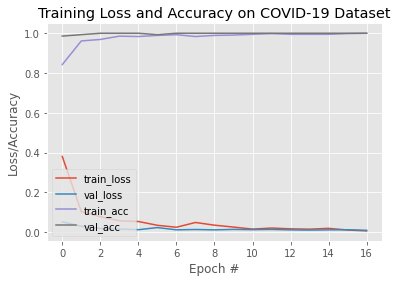

In [0]:
# plot losses and accuracy

N = len(H.history["accuracy"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [0]:
# save model to disk
print("[INFO] saving COVID-19 detector model...")
model.save("covid19_2.model", save_format="h5")

[INFO] saving COVID-19 detector model...


In [0]:
!nvidia-smi

Mon May 18 18:27:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    68W / 149W |   7913MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# load the VGG16 pretrained model
baseModel = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the new head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


# place the new head model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze the base model
for layer in baseModel.layers:
	layer.trainable = False

In [0]:
# compile model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [0]:
# train model
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
	callbacks=[my_callback, lr_callback])

[INFO] training head...


NameError: ignored

In [0]:
# predict data test
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

In [0]:
# compute the confusion matrix, accuracy, sensitivity, and specificity

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [0]:
# plot losses and accuracy

N = len(H.history["accuracy"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [0]:
# save model to disk
print("[INFO] saving COVID-19 detector model...")
model.save("covid19_Resnet50V2.model", save_format="h5")

# EVALUATION TEST


In [0]:
#ResNet152V2

In [0]:
# load the VGG16 pretrained model
baseModel = ResNet152V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the new head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


# place the new head model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze the base model
for layer in baseModel.layers:
	layer.trainable = False

234553344/234545216 [==============================] - 3s 0us/step


In [0]:
# compile model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


NameError: ignored

In [0]:
# train model
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS
	# ,
	# callbacks=[my_callback, lr_callback]
	)

In [0]:
# predict data test
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

In [0]:
# compute the confusion matrix, accuracy, sensitivity, and specificity

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [0]:
# plot losses and accuracy

N = len(H.history["accuracy"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [0]:
# load the VGG16 pretrained model
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the new head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


# place the new head model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze the base model
for layer in baseModel.layers:
	layer.trainable = False

In [0]:
# compile model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [0]:
# train model Resnet50v2
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

In [0]:
# train model ResNet152V2
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
	callbacks=[my_callback, lr_callback]
	)

In [0]:
# predict data test
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

In [0]:
# compute the confusion matrix, accuracy, sensitivity, and specificity

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [0]:
!nvidia-smi